# Working on ExperimentLoader

In [3]:
import sys, json, os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import multiomic_transformer.utils.experiment_loader as experiment_loader

GROUND_TRUTH_DIR = Path("data/ground_truth_files")

## Load Model

In [4]:
from importlib import reload

reload(experiment_loader)

<module 'multiomic_transformer.utils.experiment_loader' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/utils/experiment_loader.py'>

In [5]:
exp = experiment_loader.ExperimentLoader(
    experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
    experiment_name="Macrophage_buffer_2_best_settings",
    model_num=1,
)

exp.load_trained_model("trained_model.pt")

## Pre-load Ground Truth DataFrames

In [6]:
def load_ground_truth(ground_truth_file):
    if type(ground_truth_file) == str:
        ground_truth_file = Path(ground_truth_file)
        
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep, on_bad_lines="skip", engine="python")
    
    if "chip" in ground_truth_file.name and "atlas" in ground_truth_file.name:
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    if ground_truth_df.columns[0] != "Source" or ground_truth_df.columns[1] != "Target":
        ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
    
    # Build TF, TG, and edge sets for quick lookup later
    gt = ground_truth_df[["Source", "Target"]].dropna()

    gt_tfs = set(gt["Source"].unique())
    gt_tgs = set(gt["Target"].unique())
    
    gt_pairs = (gt["Source"] + "\t" + gt["Target"]).drop_duplicates()
    
    gt_lookup = (gt_tfs, gt_tgs, set(gt_pairs))
        
    return ground_truth_df, gt_lookup

gt_by_dataset_dict = {
    "Macrophage": {
        "RN204": load_ground_truth(GROUND_TRUTH_DIR / "rn204_macrophage_human_chipseq.tsv"),
        "ChIP-Atlas macrophage": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_macrophage.csv"),
    },
    "mESC": {
        "ChIP-Atlas mESC": load_ground_truth(GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv"),
        "RN111": load_ground_truth(GROUND_TRUTH_DIR / "RN111.tsv"),
        "RN112": load_ground_truth(GROUND_TRUTH_DIR / "RN112.tsv"),
        "RN114": load_ground_truth(GROUND_TRUTH_DIR / "RN114.tsv"),
        "RN116": load_ground_truth(GROUND_TRUTH_DIR / "RN116.tsv"),        
    },
    "K562": {
        "ChIP-Atlas K562": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_K562.csv"),
        "RN117": load_ground_truth(GROUND_TRUTH_DIR / "RN117.tsv"),        
    }
}

## Show Model Settings and Training Parameters

In [7]:
experiment_settings = exp.experiment_settings_df
experiment_settings

,parameter,value
0,EXPERIMENT_NAME,buffer_2_best_settings
1,DATASET_NAME,Macrophage_buffer_2_best_settings
2,ORGANISM_CODE,hg38
3,SAMPLE_NAMES,buffer_2
4,VALIDATION_DATASETS,buffer_4
...,...,...
67,SUBSAMPLE_MAX_WINDOWS_PER_CHROM,NaN
68,SUBSAMPLE_MAX_CELLS,NaN
69,SUBSAMPLE_SEED,42
70,ALLOWED_SAMPLES,NaN


In [8]:
for k, v in exp.model_training_params.items():
    print(f"{k}: {v}")

allowed_samples: None
epochs: 350
batch_size: 16
grad_accum_steps: 1
use_grad_accum: True
use_grad_ckpt: True
d_model: 192
num_heads: 4
num_layers: 3
d_ff: 768
dropout: 0.1
use_shortcut: True
use_dist_bias: True
use_motif_mask: True
motif_mask_threshold: 0.0
motif_prior_scale: 0.0
shortcut_l1: 0.0
shortcut_l2: 0.0
shortcut_dropout: 0.0
shortcut_topk: None
lr: 0.00025
genes: 3585
windows: 8527
tfs: 277
metacells: 147


## Plot the Training Figures

### GPU Usage

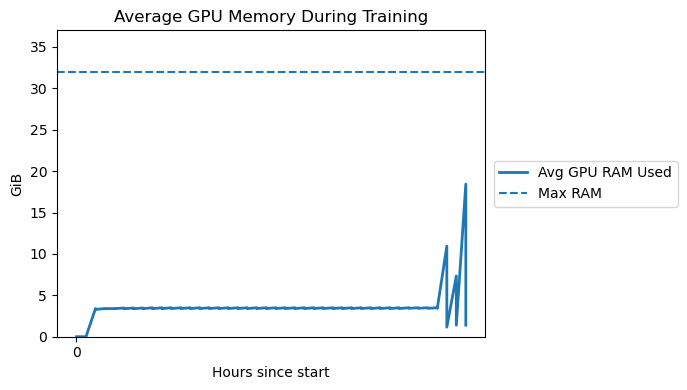

In [9]:
fig = exp.plot_gpu_usage()
fig.show()

### Correlation btw True and Predicted TG Expression

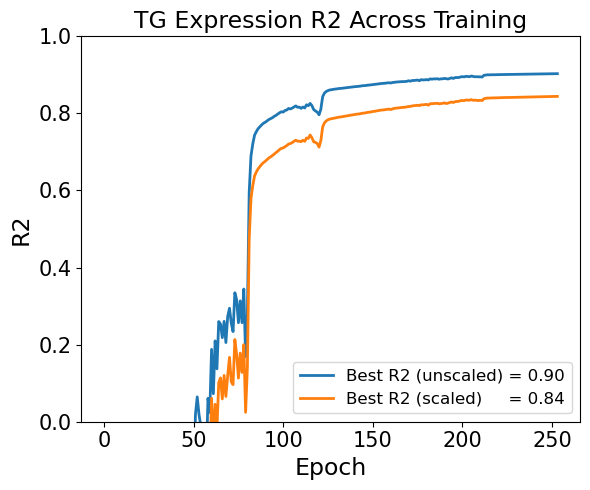

In [10]:
fig = exp.plot_train_correlation()
fig.show()

### AUROC boxplots compared to other methods

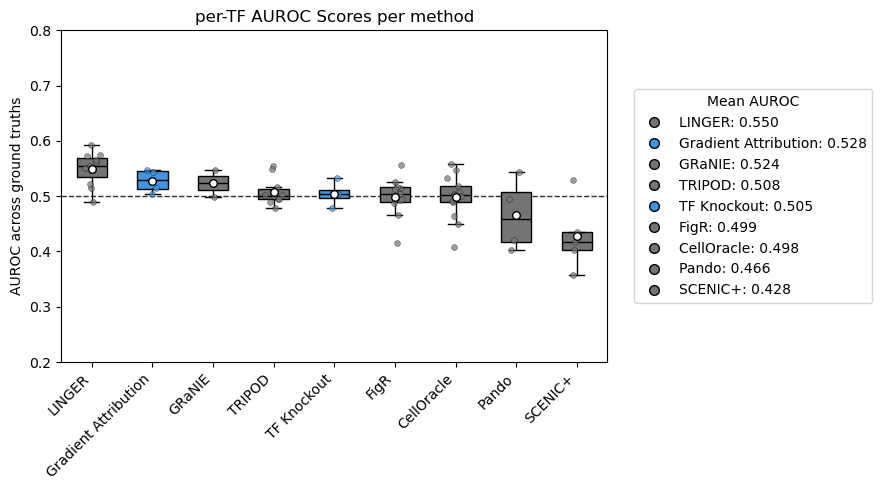

In [11]:
fig = exp.plot_per_tf_auroc_boxplot(agg_by_gt=False, ylim=(0.2, 0.8))
fig.show()

## Load the Inferred GRNs

In [12]:
grad_df = exp.load_grn("Gradient Attribution")
grad_df

,Source,Target,Score
0,ADNP2,5S_RRNA,0.0
1,ADNP2,5_8S_RRNA,0.0
2,ADNP2,7SK,0.0
3,ADNP2,A1BG,0.0
4,ADNP2,A1BG-AS1,0.0
...,...,...,...
11461978,ZSCAN30,ZYG11B,0.0
11461979,ZSCAN30,ZYX,0.0
11461980,ZSCAN30,ZYXP1,0.0
11461981,ZSCAN30,ZZEF1,0.0


In [13]:
tf_ko_df = exp.load_grn("TF Knockout")
tf_ko_df

,Source,Target,Score
0,ADNP2,5S_RRNA,0.0
1,ADNP2,5_8S_RRNA,0.0
2,ADNP2,7SK,0.0
3,ADNP2,A1BG,0.0
4,ADNP2,A1BG-AS1,0.0
...,...,...,...
11461978,ZSCAN30,ZYG11B,0.0
11461979,ZSCAN30,ZYX,0.0
11461980,ZSCAN30,ZYXP1,0.0
11461981,ZSCAN30,ZZEF1,0.0


## Plot the AUROC and AUPRC curves vs a Ground Truth

Experiment: Macrophage_buffer_2_best_settings, Sample type: Macrophage, Ground truth: RN204
            GRN  Ground Truth RN204  Overlap (Score DF in GT)  \
TFs         277                  24                         3   
TGs       41379               26696                     25111   
edges  11461983              169972                     75333   

       Pct of GRN in GT  Pct of GT in GRN  
TFs                1.08             12.50  
TGs               60.69             94.06  
edges              0.66             44.32  


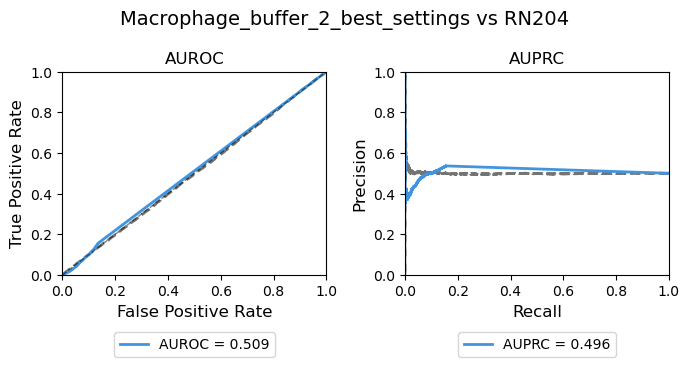

In [14]:

sample_type = exp.experiment_name.split("_")[0]
ground_truth_name = list(gt_by_dataset_dict[sample_type].keys())[0]
print(f"Experiment: {exp.experiment_name}, Sample type: {sample_type}, Ground truth: {ground_truth_name}")

gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]
grad_df = exp.load_grn("Gradient Attribution")

fig, overlap_info_df = exp.plot_auroc_auprc(
    grad_df, 
    gt_df, 
    ground_truth_name=ground_truth_name, 
    return_overlap_info=True,
    balance=True,
    save_fig=True,
    )
fig.show()

print(overlap_info_df)


## Generate performance metrics for multiple experiments

In [ ]:
experiments = [
    "Macrophage_buffer_1_hvg_filter_disp_0.01",
    # "Macrophage_buffer_2_hvg_filter_disp_0.01",
    # "Macrophage_buffer_3_hvg_filter_disp_0.01",
    # "Macrophage_buffer_4_hvg_filter_disp_0.01",
    # "Macrophage_buffer_2_hvg_filter_none",
    # "Macrophage_buffer_1_best_settings",
    # "Macrophage_buffer_2_best_settings",
    # "Macrophage_all_bnchmk_best_settings",
    "mESC_E7.5_rep1_hvg_filter_disp_0.01",
    # "mESC_E7.5_rep1_hvg_filter_disp_0.5",
    # "mESC_E7.5_rep2_hvg_filter_disp_0.01",
    "mESC_E7.5_rep2_hvg_filter_disp_0.5",
    # "mESC_E8.5_rep1_hvg_filter_disp_0.01",
    # "mESC_E8.5_rep1_hvg_filter_disp_0.5",
    # "mESC_E8.5_rep2_hvg_filter_disp_0.01",
    # "mESC_E8.5_rep2_hvg_filter_disp_0.5",
    # "mESC_E7.5_rep1_best_settings",
    # "mESC_E7.5_rep2_best_settings",
    # "mESC_E8.5_rep1_best_settings",
    "K562_hvg_filter_disp_0.01",
    # "K562_hvg_filter_disp_0.5",
    # "K562_hvg_filter_none",
    # "K562_sample_1_best_settings"
]

all_gt_results = []
for experiment_name in experiments:
    print(f"Processing experiment: {experiment_name}")
    if "macrophage" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["Macrophage"]
        sample_type = "Macrophage"
    elif "mesc" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["mESC"]
        sample_type = "mESC"
    elif "k562" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["K562"]
        sample_type = "K562"
        
    exp = experiment_loader.ExperimentLoader(
        experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
        experiment_name=experiment_name,
        model_num=1,
    )

    grad_df = exp.load_grn("Gradient Attribution")
        
    for gt_name, gt_df in gt_dict.items():
        print(f"  - Processing ground truth: {gt_name}")
        fig, overlap_info_df = exp.plot_auroc_auprc(
            grad_df, 
            gt_df, 
            ground_truth_name=gt_name, 
            return_overlap_info=True,
            balance=True,
            no_fig=True,
            )
        results_dict = {
            "sample_type": sample_type,
            "experiment": experiment_name,
            "ground_truth": gt_name,
            "num_tf_in_gt": overlap_info_df.loc["TFs", "Overlap (Score DF in GT)"],
            "pct_tf_overlap": overlap_info_df.loc["TFs", "Pct of GRN in GT"],
            "pct_tg_overlap": overlap_info_df.loc["TGs", "Pct of GRN in GT"],
            "pct_edges_in_gt": overlap_info_df.loc["edges", "Pct of GRN in GT"],
        }

        results_df = pd.DataFrame(results_dict, index=[0])
        
        merged_results = pd.merge(results_df, exp.auroc_auprc_scores, on=["experiment", "ground_truth"], how="left")
        
        all_gt_results.append(merged_results)

full_results_df = pd.concat(all_gt_results, axis=0)
full_results_df


Processing experiment: Macrophage_buffer_1_hvg_filter_disp_0.01
  - Processing ground truth: RN204
  - Processing ground truth: ChIP-Atlas macrophage
Processing experiment: mESC_E7.5_rep1_hvg_filter_disp_0.01
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Processing experiment: mESC_E7.5_rep2_hvg_filter_disp_0.5
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Processing experiment: K562_hvg_filter_disp_0.01
  - Processing ground truth: ChIP-Atlas K562
  - Processing ground truth: RN117


In [ ]:
def plot_auroc_improvement_boxplot(
    full_results_df, 
    column="auroc", 
    title="AUROC Variance across Ground Truths",
    hbar_y=0,
    ylim=(-0.3, 0.3)
    ):
    # ---- group data by ground_truth ----
    groups = full_results_df.groupby("ground_truth")[column]
    labels = groups.groups.keys()
    data = [groups.get_group(g).values for g in labels]

    color_dict = {
        "ChIP-Atlas mESC": "#da8b47",
        "ChIP-Atlas macrophage": "#e67d5f",
        "ChIP-Atlas K562": "#dab45d",
        "RN111": "#71c071",
        "RN112": "#ba4444",
        "RN114": "#cbb4e1",
        "RN116": "#91645b",
        "RN117": "#d8aacb",
        "RN204": "#9ec5e1",
    }

    means = [np.mean(groups.get_group(g)) for g in labels]

    plt.figure(figsize=(10, 6))
    # ---- boxplot ----
    bp = plt.boxplot(
        data,
        patch_artist=True,
        showfliers=False,
        zorder=1,
    )

    plt.axhline(hbar_y, color="#747474", linestyle="--")


    # ---- color boxes ----
    for label, box in zip(labels, bp["boxes"]):
        box.set_facecolor(color_dict.get(label, "#4195df"))
    for median in bp["medians"]:
        median.set_color("black")

    # ---- scatter points ----
    for i, g in enumerate(labels, start=1):
        yvals = groups.get_group(g).values
        xvals = np.random.normal(i, 0.05, size=len(yvals))  # jitter per box
        
        plt.scatter(
            xvals,
            yvals,
            color=color_dict.get(g, "#4195df"),
            alpha=0.7,
            s=40,
            edgecolor="k",
            zorder=2
        )

    # ---- plot mean per ground_truth ----

    plt.scatter(
        range(1, len(means) + 1),
        means,
        color="white",
        s=60,
        edgecolor="k",
        zorder=3,
    )

    # ---- formatting ----
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel(f"{column}\n(per experiment)", fontsize=14)
    plt.title(f"{title}", fontsize=14)

    # ---- plot mean per ground_truth + build legend ----
    legend_handles = []

    for i, (g, m) in enumerate(zip(labels, means), start=1):
        h = plt.scatter(
            i,
            m,
            color="white",
            s=70,
            edgecolor="k",
            zorder=3,
            label=f"{g} mean = {m:.3f}"
        )
        legend_handles.append(h)


    plt.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.02, 0.75),
        loc="upper left",
        frameon=False,
        fontsize=12,
        title="Mean AUROC",
        title_fontsize=14,
    )

    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


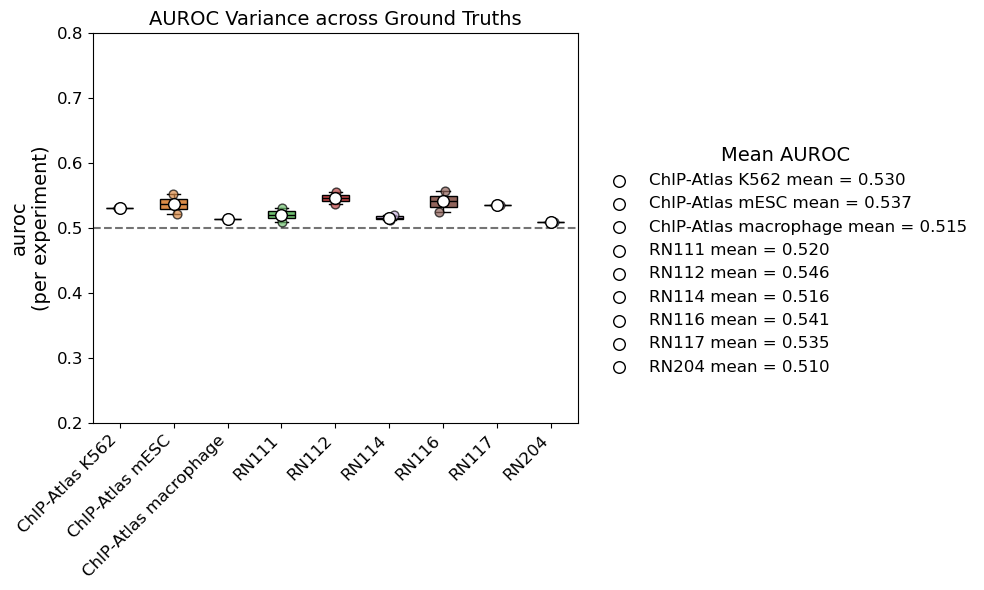

In [ ]:
plot_auroc_improvement_boxplot(
    full_results_df, 
    ylim=(0.2, 0.8),
    hbar_y=0.5
    )


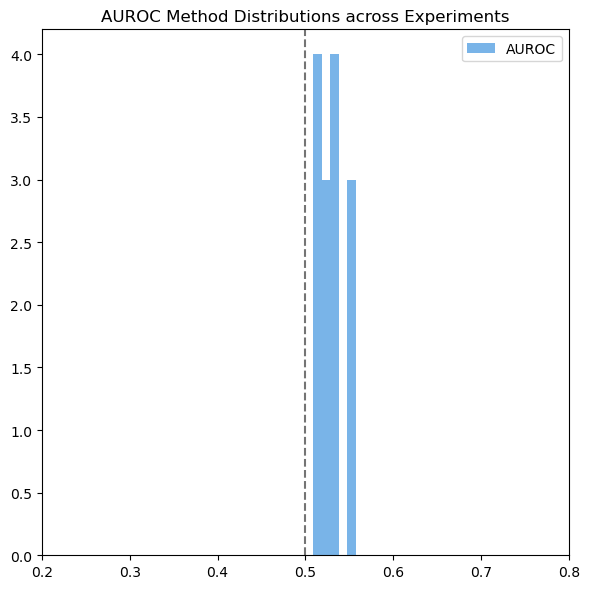

In [ ]:
fig = plt.figure(figsize=(6, 6))

plt.hist(full_results_df["auroc"], bins=5, color="#4195df", alpha=0.7, label="AUROC")
plt.axvline(0.5, color="#747474", linestyle="--")
plt.legend()
plt.xlim(0.2, 0.8)
plt.title("AUROC Method Distributions across Experiments")
plt.tight_layout()
plt.show()


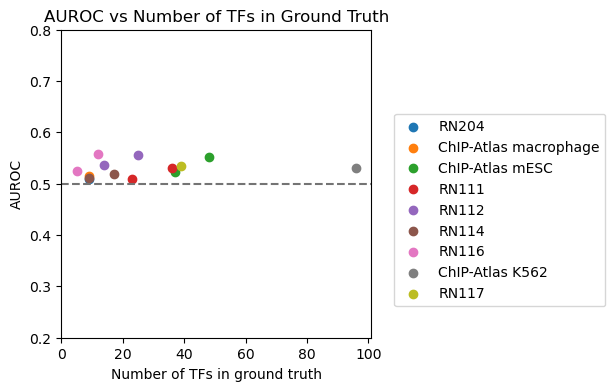

In [ ]:
# Scatterplot of auroc vs percent of tf overlap in gt
plt.figure(figsize=(4,4))
# df = full_results_df[full_results_df["sample_type"] == "K562"]
df = full_results_df
for gt_name in df["ground_truth"].unique():
    subset = df[df["ground_truth"] == gt_name]
    plt.scatter(subset["num_tf_in_gt"], subset["auroc"], label=gt_name)
plt.title("AUROC vs Number of TFs in Ground Truth")
plt.xlabel("Number of TFs in ground truth")
plt.ylabel("AUROC")
plt.hlines(0.5, xmin=0, xmax=df["num_tf_in_gt"].max() +5, color="#747474", linestyle="--")
plt.legend(
    bbox_to_anchor=(1.05, 0.75), loc='upper left'
)

plt.ylim(0.2, 0.8)
plt.xlim(0, df["num_tf_in_gt"].max() + 5)

plt.show()

### Load the AUROC and AUPRC comparison results

In [ ]:
exp.load_eval_results()
results_df = exp.results_df[exp.results_df["method"] == "Gradient Attribution"]
results_df

,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,precision@1.00%,lift@1.00%,precision@5.00%,lift@5.00%
14,Gradient Attribution,ChIP-Atlas,0.530222,0.522556,0.5,1.045112,0.793307,1.586614,0.747606,1.495212,0.715813,1.431626,0.663536,1.327072
15,Gradient Attribution,RN117,0.535325,0.525976,0.5,1.051951,0.977011,1.954023,0.816280,1.632559,0.705792,1.411585,0.636642,1.273284


## Compare Predicted vs True TG Expression

In [ ]:
tg_expr_pred_df, tg_expr_true_df, pred_true_comparison_df = exp.run_forward_pass(num_batches=15)

predicted_expr = tg_expr_pred_df.copy()
predicted_expr["mean_expr"] = predicted_expr.mean(axis=1).values
predicted_expr["std_expr"] = predicted_expr.std(axis=1).values
predicted_expr = predicted_expr[["mean_expr", "std_expr"]]

true_expr = tg_expr_true_df
true_expr["mean_expr"] = true_expr.mean(axis=1).values
true_expr["std_expr"] = true_expr.std(axis=1).values
true_expr = true_expr[["mean_expr", "std_expr"]]

merged = predicted_expr.merge(
    true_expr,
    left_index=True,
    right_index=True,
    suffixes=("_pred", "_true")
)

merged["diff"] = merged["mean_expr_pred"] - merged["mean_expr_true"]

merged

,mean_expr_pred,std_expr_pred,mean_expr_true,std_expr_true,diff
ABCB10,0.840964,0.021103,0.949976,0.026615,-0.109012
ABCD3,0.342700,0.006022,0.356519,0.001581,-0.013819
ACBD3,0.752947,0.014699,0.763130,0.009845,-0.010183
ADAM15,0.141834,0.007495,0.137909,0.001659,0.003925
ADAMTSL4,0.656218,0.009612,0.697135,0.005623,-0.040916
...,...,...,...,...,...
VPS18,0.072015,0.006375,0.075225,0.000586,-0.003210
WDR76,0.496881,0.026021,0.543455,0.016861,-0.046574
WHAMM,0.208155,0.006856,0.204399,0.001209,0.003756
ZNF280D,0.801071,0.024301,0.867700,0.007061,-0.066629


### Plot the True vs Predicted TG Expression Values

Running forward pass to get predicted vs true TG expression for a subset of test batches...


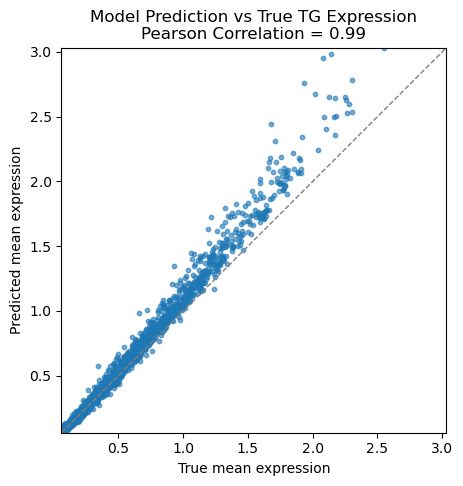

In [ ]:
fig = exp.plot_true_vs_predicted_tg_expression(num_batches=25, rerun_forward_pass=False)
fig.show()

In [ ]:
x = exp.tg_prediction_df.mean(axis=1).values
y = exp.tg_true_df.mean(axis=1).values

x = np.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
y = np.nan_to_num(y, nan=0.0, posinf=1e6, neginf=-1e6)

print("True min:", x.min())
print("Pred min:", y.min())


True min: 0.059382897
Pred min: 0.062073812


The `tg_prediction_df` and `tg_true_df` DataFrames store the predicted and true TG expression values for each cellfrom the forward pass.

In [ ]:
exp.tg_true_df

,batch0_cell0,batch0_cell1,batch0_cell2,batch0_cell3,batch0_cell4,batch0_cell5,batch0_cell6,batch0_cell7,batch0_cell8,batch0_cell9,...,batch21_cell22,batch21_cell23,batch21_cell24,batch21_cell25,batch21_cell26,batch21_cell27,batch21_cell28,batch21_cell29,batch21_cell30,batch21_cell31
ABCB10,0.926818,0.960827,0.920339,0.982129,0.953472,0.954774,0.967355,1.012054,0.909932,0.995361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABCD3,0.353203,0.357209,0.355471,0.356768,0.358506,0.356704,0.355480,0.354757,0.357853,0.355770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACBD3,0.787325,0.754690,0.756774,0.762881,0.753344,0.749768,0.750559,0.770920,0.768407,0.773840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAM15,0.135259,0.139420,0.137448,0.136334,0.140159,0.140428,0.137798,0.134236,0.136890,0.136278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAMTSL4,0.695993,0.695268,0.690049,0.696079,0.694392,0.697864,0.701299,0.709145,0.692011,0.704009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UQCR10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.202782,0.208395,0.206427,0.206185,0.202774,0.206573,0.209616,0.205724,0.206142,0.208159
XBP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.487545,0.495243,0.489708,0.491161,0.487567,0.492254,0.496252,0.487973,0.488709,0.493114
YDJC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.517927,0.557924,0.530134,0.531818,0.517531,0.536718,0.558423,0.524899,0.531904,0.553213
ZNF280A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071542,0.072139,0.072837,0.072408,0.071466,0.073286,0.071922,0.072635,0.072624,0.072203


### Plot Prediction Accuracy vs Gene Expression Variance

0.8211941712524172


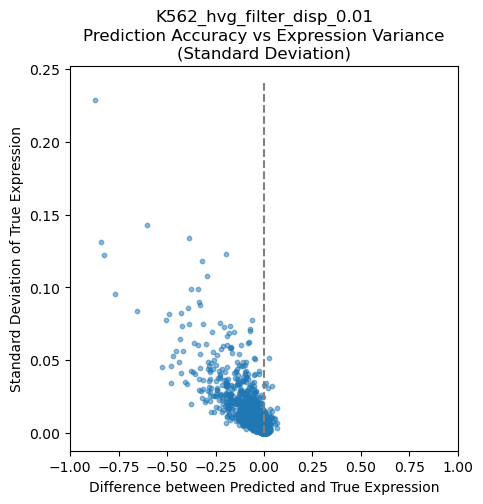

In [ ]:
fig = plt.figure(figsize=(5,5))

plt.scatter(merged["diff"], merged["std_expr_true"], alpha=0.5, s=10)

lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),  # min of both axes
    np.max([plt.xlim()[1], plt.ylim()[1]]),  # max of both axes
]
plt.vlines(x=0, ymin=0, ymax=lims[1], colors='grey', linestyles='dashed', label="Perfect Prediction")
plt.xlim(lims)
plt.title(f"{exp.experiment_name}\nPrediction Accuracy vs Expression Variance\n(Standard Deviation)")
plt.xlabel("Difference between Predicted and True Expression")
plt.ylabel("Standard Deviation of True Expression")
plt.xlim(-1, 1)

variance_pred_accuracy_corr = np.corrcoef(np.abs(merged["diff"]), merged["std_expr_true"])[0,1]
print(variance_pred_accuracy_corr)

plt.show()